In [19]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/jorge/thesis')

import torch
from einops import rearrange
from text3d2video.utilities.testing_utils import test_img
import torchvision.transforms.functional as TF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [348]:
def frame_test_features(txt="", color="red", res=100):
    frame_pt = test_img(txt=txt, color=color, resolution=res, return_type="pt")
    frame_pt_flat = rearrange(frame_pt, "c h w -> (h w) c")
    return frame_pt_flat


def make_test_features(n_frames, chunks, res=100):
    all_frames = []
    for chunk in chunks:
        chunk_frames = []
        for f_i in range(n_frames):
            frame_pt_flat = frame_test_features(txt=str(f_i), color=chunk, res=res)
            chunk_frames.append(frame_pt_flat)
        chunk_frames = torch.stack(chunk_frames)
        all_frames.append(chunk_frames)
    all_frames = torch.cat(all_frames)
    return all_frames


n_frames = 3
chunks = ["red", "blue"]
n_chunks = len(chunks)
res = 64

kv_features = make_test_features(n_frames, chunks, res=64)

kv_features.shape

torch.Size([6, 4096, 3])

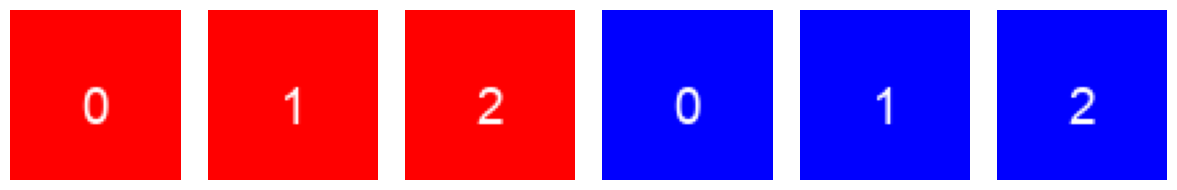

In [356]:
from text3d2video.utilities.ipython_utils import display_ims

kv_features_2D = rearrange(kv_features, "b (h w) c -> b c h w", h=res)
kv_features_2D_pil = [TF.to_pil_image(f) for f in kv_features_2D]
display_ims(kv_features_2D_pil)

In [357]:
from text3d2video.utilities.attention_utils import extend_across_frame_dim


injected_features = torch.stack([frame_test_features("injected", chunk, res) for chunk in chunks])
injected_features_frame = extend_across_frame_dim(injected_features, n_frames)

In [359]:
from text3d2video.util import chunk_dim
from text3d2video.utilities.attention_utils import (
    extend_across_frame_dim,
)

attend_to_chunk = True
attend_to_self = True
inject_features = True

if attend_to_chunk:
    attend_to_self = False

kvs = []

if attend_to_chunk:
    x_chunked = chunk_dim(kv_features, n_chunks)

    chunk_kvs = rearrange(x_chunked, "n_chunks f t d -> n_chunks (f t) d")

    extended_frame_kvs = extend_across_frame_dim(chunk_kvs, n_frames)

    # extended_frame_kvs = expand_singleton_dim(chunk_kvs.unsqueeze(0), n_frames, dim=0)
    # extended_frame_kvs = extended_frame_kvs.flatten(0, 1)
    kvs.append(extended_frame_kvs)

if attend_to_self:
    self_kvs = kv_features
    kvs.append(self_kvs)

if inject_features:
    kvs.append(injected_features_frame)

assert len(kvs) > 0, "Cannot attend to nothing"

kvs = torch.cat(kvs, dim=1)
kvs.shape

torch.Size([6, 16384, 3])

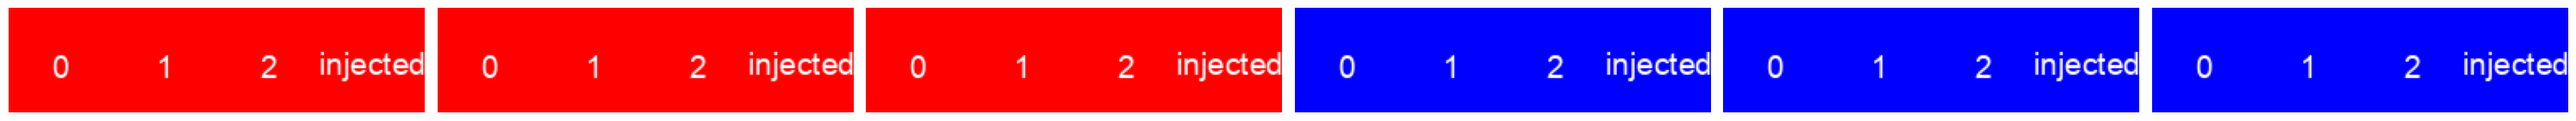

In [361]:
from text3d2video.utilities.attention_utils import reshape_kvs_2D


kvs_square = reshape_kvs_2D(kvs, res=res)
kv_ims = [TF.to_pil_image(k) for k in kvs_square]
display_ims(kv_ims, scale=5)